1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


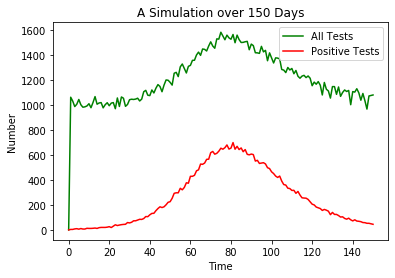

In [1]:
# Raw code for epidemic simulation

import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import sys
sys.path.append("..")
import ODE_Dynamics as od
import math
from random import sample

# Return number tested, number of positives, new infections and true negative tests
n_tests = [0]; n_positives = [0]; 
n_new_infections = [] ; n_true_negatives = [0]; n_false_positives = [0];

# Set population size and duration of the epidemic
pop_size = 10000
pop_id = [id for id in range(pop_size)]
duration = 150

# Set parameters for epidemic model
R0 = 1.8
mu = 5.0E-08
nu = 0.1
par=tf.constant(np.array([[R0, mu, nu]], dtype = np.float32))

# Set parameters for viral load model
mu_b, sigma_b = 5, 1

# Find viral load threshold: 1E-05 of the maximum load
# Example 1: Threshold for COVID-19 RT-PCR test is 6.25 cp/μL. Maximum load about 625500
# Example 2: HIV load ranges about (1E4, 1E6). Threshold is 20 for RT-PCR
# v_threshold = 170306.4 * 1E-02

# New viral threshold: approx. typical viral load after 5 days of infection

v_threshold = 170306.4 * 1E-05
# 10000

# Set probability of exhibiting symptom (studies show about 0.55)
prob_s_i = 0.55
# Probability of symptoms and no infection
# Every year 9% of world population is infected by seasonal flu
prob_s_ibar = 0.1  
# 10% of all uninfected individuals are symptomatic
# False postive probability
prob_fp = 0

# Get epidemic model
mod = od.SIR(par)

# At the start of the epidemic most people are succeptible
init_state=tf.constant(np.array([[0.001,0.999]], dtype=np.float32))

# Generate time stamps for duration of epidemic
init_time=tf.constant(0)
num = int(duration)
soln_times=tf.constant(np.linspace(0, duration, num, dtype=np.int32))

# Get I, S, R values through duration of the epidemic
dp = tfp.math.ode.DormandPrince()
results = dp.solve(mod.RHS, init_time, init_state, solution_times=soln_times)
t = results.times
i = results.states[:,0,0] ; s = results.states[:,0,1] ; r = 1.0 - i - s;

# Before epidemic everybody is succeptible
I = []
S = pop_id
R = []

# Record id of individuals in I, S, R compartments at time = 0

time = 0
n_i = int(pop_size * i.numpy()[time])
n_s = int(pop_size * s.numpy()[time])
n_r = int(pop_size * r.numpy()[time])

I = sample(pop_id, n_i)
S = [id for id in S if id not in I]
R = []

n_new_infections.append(len(I))

# Record time stamp of infection for each infected individual

I_T = [0] * len(I)

# Record people who tested positive

positives = []

while time < duration-1:
    
    time += 1
    
    # New births
    n_b = math.floor(mu * len(S))
    pop_size += n_b
    
    if n_b > 0:
        id_first = pop_size + 1
        id_last = id_first + n_b -1
        new_id = [id for id in range(id_first, id_last, 1)]
        S.append(new_id)
    
    # Removal by death
    s1 = math.floor(mu * len(S))
    if s1 > 0:
        S1 = sample(S, s1)
        S = [id for id in S if id not in S1]

    i1 = math.floor(mu * len(I))
    if i1 > 0:
        I1 = sample(I, i1)
        for id in I1:
            ind = I.index(id)
            print(ind, len(I_T), len(I))
            del I_T[ind]
            del I[ind]
        
    r1 = math.floor(mu * len(R))
    if r1 > 0:
        R1 = sample(R, r1)
        R = [id for id in R if id not in R1]

    pop_size = pop_size - s1 - i1 -r1
    
    n_i0 = int(pop_size * i.numpy()[time-1])
    n_s0 = int(pop_size * s.numpy()[time-1])
    n_r0 = pop_size - n_i0 - n_s0
    
    n_i = int(pop_size * i.numpy()[time])
    n_s = int(pop_size * s.numpy()[time])
    n_r = pop_size - n_i - n_s
    
    # New numbers of I, S, R at time
    dn_s = n_s0 - n_s; dn_r = n_r - n_r0
    
    n_new_infections.append(dn_s)
    
    # Update I, S, R compartments
    if dn_s <= len(S):
        I0 = sample(S, dn_s)
        S = [id for id in S if id not in I0]
        I = I + I0
        I_T = I_T + [time] * len(I0)
    else:
        I = I + S
        S = []
    
    if dn_r <= len(I):
        R0 = sample(I, dn_r)
        for id in R0:
            ind = I.index(id)
            del I_T[ind]
            del I[ind]
        R = R + R0
    else:
        R = R + I
        I = []
        I_T = []
        break
    
    # Choose infected individuals who are symptomatic
    smp_i = []; I_T_smp = []
    for id in range(len(I)):
        if int(np.random.binomial(size = 1, n = 1, p = prob_s_i))== 1:
            smp_i.append(I[id])
            I_T_smp.append(I_T[id])
    
    # Choose healthy individuals who are symptomatic
    S_R = S + R
    smp_ibar = [id for id in S_R if int(np.random.binomial(size = 1, n = 1, p = prob_s_ibar))== 1]
    
    # All symptomatic individual
    smp = smp_i + smp_ibar
    T_smp = I_T_smp + [-1] * len(smp_ibar)
    
    # Only those individuals are tested who have never been tested positive
    tested = [id for id in smp if id not in positives]
    n_tests.append(len(tested))
    
    # Find viral load of infected individuals being tested
    
    # Determine which individuals are tested positive
    
    # Positives among infected
    pos1 = []
    
    # Find viral load of all infected individuals being tested
    smp_i_tested = [id for id in smp_i if id in tested]
    for id in range(len(smp_i_tested)):
        tau = time - I_T_smp[id]
        beta = np.random.normal(mu_b, sigma_b, 1)
        L = 0.0025/beta
        par=tf.constant(np.array([[L,0.01,beta*1E-7,0.5,20,10]], dtype=np.float32))
        mod = od.ViralDynamics(par)
        V0 = np.random.normal(1E3, 1E2, 1)
        X0 = 1E6
        Y0 = V0
        init_state=tf.constant(np.array([[V0,X0,Y0]], dtype=np.float32))
        init_time=tf.constant(0.0)
        soln_times=tf.constant(np.linspace(0.0,tau+1,num=tau+1,dtype=np.float32))
        dp = tfp.math.ode.DormandPrince()
        results = dp.solve(mod.RHS, init_time, init_state, solution_times=soln_times)
        v = results.states[:,0,0]
        v_tau = v[...,-1].numpy()
        if v_tau > v_threshold:
            pos1.append(1)
        else:
            pos1.append(0)
    
    # Positives among uninfected
    pos2 = [id for id in smp_ibar if int(np.random.binomial(1, prob_fp, 1)) == 1]
    n_true_negatives.append(len(tested) - len(smp_i_tested))
    n_false_positives.append(len(pos2))
    
    # All positive tests
    pos = pos1 + pos2
    n_positives.append(sum(pos))
    
    # Update historical set of all positive individuals
    positives = positives + pos
    
    print(time)
    
import matplotlib.pyplot as plt
plt.plot(t, n_tests,"g-", t, n_positives, "r-")
plt.legend(['All Tests','Positive Tests'],loc = 'upper right')
plt.xlabel('Time')
plt.ylabel('Number')
plt.title("A Simulation over 150 Days")
plt.savefig('simulation_ignite.png', dpi=300, bbox_inches='tight')

simulation_results = np.column_stack((n_tests, n_positives, n_new_infections, n_true_negatives, n_false_positives))
headings = ['Tests', 'Positives', 'New Infections', 'True Negatives', 'False Positives']
simulation_results = np.vstack([headings, simulation_results])
    
with open("simulation_July17.txt", "w") as txt_file:
    for line in simulation_results:
        txt_file.write(" ".join(line) + "\n")
